<a href="https://colab.research.google.com/github/amir1611/stroke-prediction/blob/main/project_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting Up**

Please follow the steps below to download and use kaggle data within Google Colab:

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

*   Install scikit-fuzzy
*   Install kaggle 

In [ ]:
import sys
!{sys.executable} -m pip install scikit-fuzzy
!{sys.executable} -m pip install kaggle

In [ ]:
!pip install -U scikit-fuzzy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [35]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd "/content/drive/MyDrive/Kaggle"

In [ ]:
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

In [ ]:
!unzip \*.zip   &&  rm *.zip

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
import pandas as pd

from skfuzzy import control as ctrl
from numpy import genfromtxt

# **Pre-Processing**

In [48]:
dataset = pd.read_csv('healthcare-dataset-stroke-data.csv', sep=',')

# remove NaN rows
dataset = dataset.dropna()

# convert categorial input from string to int
dataset['gender'] = dataset['gender'].map({
    'Male': 1,
    'Female': 0
})

dataset['smoking_status'] = dataset['smoking_status'].map({
    'Unknown': 0,
    'formerly smoked': 1,
    'never smoked': 2,
    'smokes': 3
})

# **Selection Of Attributes**

In [41]:
# remove unwanted attributes/column
del dataset['id']
del dataset['ever_married']
del dataset['work_type']
del dataset['Residence_type']
del dataset['hypertension']
del dataset['heart_disease']
del dataset['smoking_status']

print(dataset.columns.tolist())

['gender', 'age', 'avg_glucose_level', 'bmi', 'stroke']


# **Antecent/Consequent**

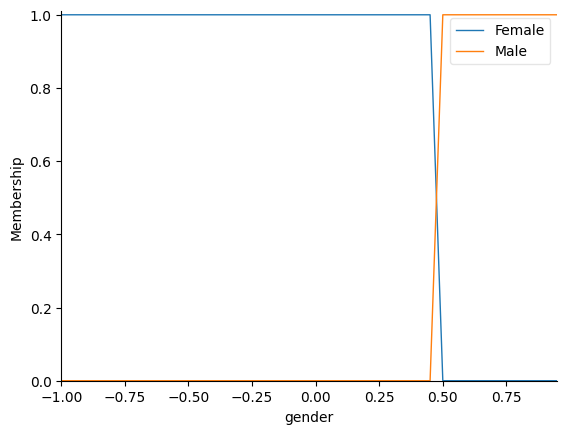

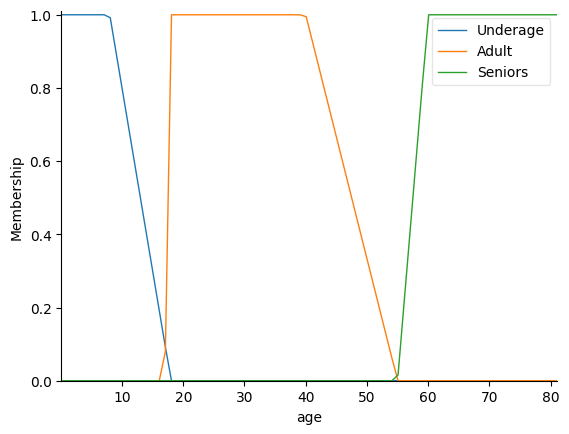

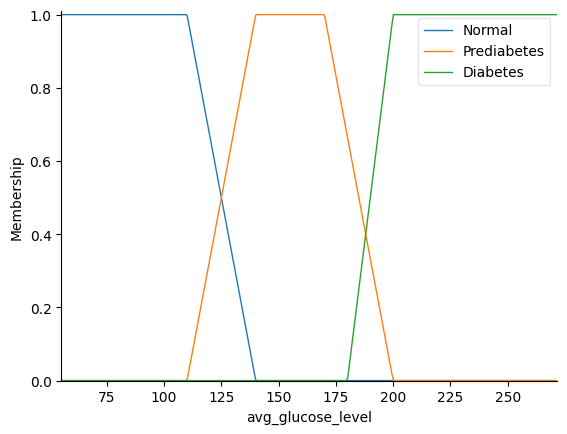

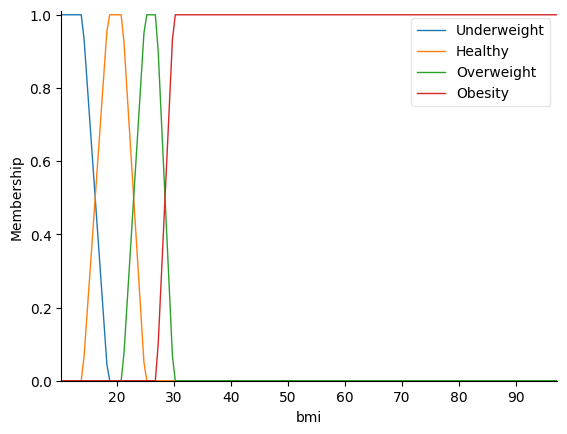

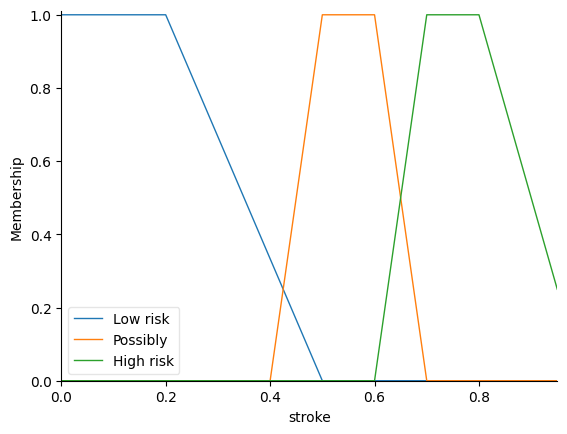

In [42]:
# Antecent
gender = ctrl.Antecedent(np.arange(-1, 1, .05), 'gender')
age = ctrl.Antecedent(np.arange(dataset['age'].min(), dataset['age'].max(), 1), 'age')
avg_glucose_level = ctrl.Antecedent(np.arange(dataset['avg_glucose_level'].min(), dataset['avg_glucose_level'].max(), 0.5), 'avg_glucose_level')
bmi = ctrl.Antecedent(np.arange(dataset['bmi'].min(), dataset['bmi'].max(), 0.5), 'bmi')
stroke = ctrl.Consequent(np.arange(dataset['stroke'].min(), dataset['stroke'].max(), .05), 'stroke', defuzzify_method='centroid')

# gender membership function
gender['Female'] = fuzz.trapmf(gender.universe, [-1, -1, .5, .5])
gender['Male'] = fuzz.trapmf(gender.universe, [.5, .5, 1, 1])

# age membership function
age['Underage'] = fuzz.trapmf(age.universe, [0, 0, 8, 18])
age['Adult'] = fuzz.trapmf(age.universe, [17, 18, 40, 55])
age['Seniors'] = fuzz.trapmf(age.universe, [55, 60, dataset['age'].max(), dataset['age'].max()])

# average glucose level membership function
avg_glucose_level['Normal'] = fuzz.trapmf(avg_glucose_level.universe, [0, 0, 110, 140])
avg_glucose_level['Prediabetes'] = fuzz.trapmf(avg_glucose_level.universe, [110, 140, 170, 200])
avg_glucose_level['Diabetes'] = fuzz.trapmf(avg_glucose_level.universe, [180, 200, dataset['avg_glucose_level'].max(), dataset['avg_glucose_level'].max()])

# bmi membership function
bmi['Underweight'] = fuzz.trapmf(bmi.universe, [0, 0, 14, 18.5])
bmi['Healthy'] = fuzz.trapmf(bmi.universe, [14, 18.5, 21., 25.])
bmi['Overweight'] = fuzz.trapmf(bmi.universe, [21., 25., 27., 30.])
bmi['Obesity'] = fuzz.trapmf(bmi.universe, [27., 30., dataset['bmi'].max(), dataset['bmi'].max()])

# stroke membership function
stroke['Low risk'] = fuzz.trapmf(stroke.universe, [0, 0, 0.2, 0.5])
stroke['Possibly'] = fuzz.trapmf(stroke.universe, [0.4, 0.5, 0.6, 0.7])
stroke['High risk'] = fuzz.trapmf(stroke.universe, [0.6, 0.7, 0.8, 1.0])

# view membership function
gender.view()
age.view()
avg_glucose_level.view()
bmi.view()
stroke.view()

# **Fuzzy Rules**

(<Figure size 640x480 with 1 Axes>, <Axes: >)

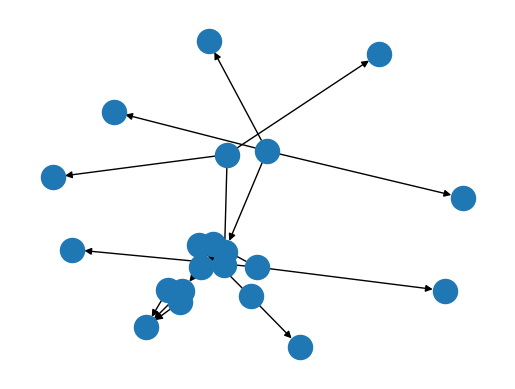

In [43]:
rule1 = ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Underweight'], stroke['Low risk'])

stroke_ctrl = ctrl.ControlSystem([
    rule1,
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Obesity'], stroke['High risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Underage'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Obesity'], stroke['High risk']),

    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Obesity'], stroke['High risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Adult'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Obesity'], stroke['Low risk']), 
     
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Underweight'], stroke['Low risk']), 
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Normal'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Normal'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Prediabetes'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Prediabetes'] & bmi['Obesity'], stroke['Possibly']),
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Female'] & avg_glucose_level['Diabetes'] & bmi['Obesity'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Underweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Healthy'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Overweight'], stroke['Low risk']),
    ctrl.Rule(age['Seniors'] & gender['Male'] & avg_glucose_level['Diabetes'] & bmi['Obesity'], stroke['High risk']),
    
])
stroke_predict = ctrl.ControlSystemSimulation(stroke_ctrl)

rule1.view()

# **Test**

In [44]:
# High risk
stroke_predict.input['gender'] = 0
stroke_predict.input['age'] = 42
stroke_predict.input['avg_glucose_level'] = 192.94
stroke_predict.input['bmi'] = 27.9

stroke_predict.compute()

# **Output**

0.3655134976771807


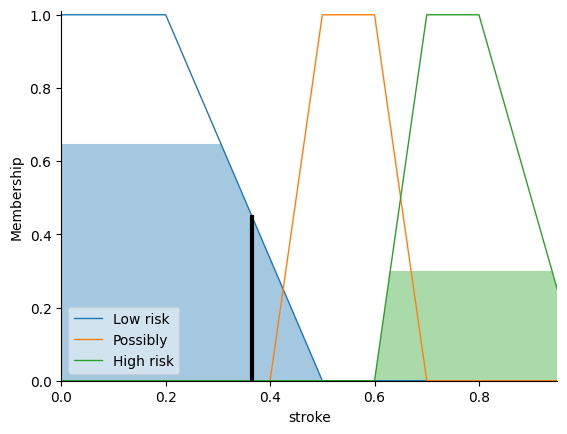

In [45]:
print(stroke_predict.output['stroke'])
stroke.view(sim=stroke_predict)

# **Evaluate using dataset**

In [46]:
result = []
predicted = []
compare = []
tr = 0

tp = 0
fn = 0
fp = 0
tn = 0

dataset.reset_index()

count = 0
for index, row in dataset.iterrows():
    print(count, row['age'], row['avg_glucose_level'], row['bmi'], row['stroke'])
    count += 1

    stroke_predict.input['age'] = row['age']
    stroke_predict.input['gender'] = row['gender']
    stroke_predict.input['avg_glucose_level'] = row['avg_glucose_level']
    stroke_predict.input['bmi'] = row['bmi']

    stroke_predict.compute()

    p = round(stroke_predict.output['stroke'], 0)

    result.append(stroke_predict.output['stroke'])

    match = p == row['stroke']

    if (match) : tr += 1

    tp += int((p == 1.) & (row['stroke'] == 1))
    fn += int((p == 0.) & (row['stroke'] == 1))
    fp += int((p == 1.) & (row['stroke'] == 0))
    tn += int((p == 0.) & (row['stroke'] == 0))

    compare.append(int(match))
    predicted.append(round(stroke_predict.output['stroke'], 0))

print('Total data:', len(dataset))
print('Total true:', tr)
print('Accuracy:', (tr/len(dataset))*100)
print('TP:', tp)
print('FN:', fn)
print('FP:', fp)
print('TN:', tn)

0 67.0 228.69 36.6 1.0
1 80.0 105.92 32.5 1.0
2 49.0 171.23 34.4 1.0
3 79.0 174.12 24.0 1.0
4 81.0 186.21 29.0 1.0
5 74.0 70.09 27.4 1.0
6 69.0 94.39 22.8 1.0
7 78.0 58.57 24.2 1.0
8 81.0 80.43 29.7 1.0
9 61.0 120.46 36.8 1.0
10 54.0 104.51 27.3 1.0
11 79.0 214.09 28.2 1.0
12 50.0 167.41 30.9 1.0
13 64.0 191.61 37.5 1.0
14 75.0 221.29 25.8 1.0
15 60.0 89.22 37.8 1.0
16 71.0 193.94 22.4 1.0
17 52.0 233.29 48.9 1.0
18 79.0 228.7 26.6 1.0
19 82.0 208.3 32.5 1.0
20 71.0 102.87 27.2 1.0
21 80.0 104.12 23.5 1.0
22 65.0 100.98 28.2 1.0
23 69.0 195.23 28.3 1.0
24 57.0 212.08 44.2 1.0
25 42.0 83.41 25.4 1.0
26 82.0 196.92 22.2 1.0
27 80.0 252.72 30.5 1.0
28 48.0 84.2 29.7 1.0
29 82.0 84.03 26.5 1.0
30 74.0 219.72 33.7 1.0
31 72.0 74.63 23.1 1.0
32 58.0 92.62 32.0 1.0
33 49.0 60.91 29.9 1.0
34 78.0 78.03 23.9 1.0
35 54.0 71.22 28.5 1.0
36 82.0 144.9 26.4 1.0
37 60.0 213.03 20.2 1.0
38 76.0 243.58 33.6 1.0
39 58.0 107.26 38.6 1.0
40 81.0 99.33 33.7 1.0
41 39.0 58.09 39.2 1.0
42 79.0 127.29 27.7 1

In [47]:
dataset.insert(5, "result", result, True)
dataset.insert(6, "compare", compare, True)
dataset.insert(7, "predicted", predicted, True)

print(dataset)

dataset.to_csv('test.csv')

      gender   age  avg_glucose_level   bmi  stroke    result  compare  \
0        1.0  67.0             228.69  36.6       1  0.775214        1   
2        1.0  80.0             105.92  32.5       1  0.185714        0   
3        0.0  49.0             171.23  34.4       1  0.221364        0   
4        0.0  79.0             174.12  24.0       1  0.199194        0   
5        1.0  81.0             186.21  29.0       1  0.475370        0   
...      ...   ...                ...   ...     ...       ...      ...   
5104     0.0  13.0             103.08  18.6       0  0.214706        1   
5106     0.0  81.0             125.20  40.0       0  0.214270        1   
5107     0.0  35.0              82.99  30.6       0  0.185714        1   
5108     1.0  51.0             166.29  25.6       0  0.230580        1   
5109     0.0  44.0              85.28  26.2       0  0.200171        1   

      predicted  
0           1.0  
2           0.0  
3           0.0  
4           0.0  
5           0.0  
...